## Q Learning

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from collections import defaultdict
import random
import math
import numpy as np


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        value = -np.inf
        for a in possible_actions:
            value = max(value, self.get_qvalue(state, a))

        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        q_val = (1-learning_rate)*self.get_qvalue(state, action) + learning_rate*(reward + gamma * self.get_value(next_state))

        self.set_qvalue(state, action, q_val)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None
        val = -np.inf
        best_action = None
        for a in possible_actions:
            if self.get_qvalue(state, a) > val:
                val = self.get_qvalue(state, a)
                best_action = a

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        if np.random.uniform(0,1) < epsilon:
            action = np.random.choice(possible_actions)
        else:
            action = self.get_best_action(state)

        return action

### Implementation on taxi env from openai gym

In [4]:
import gym
env = gym.make("Taxi-v3")

n_actions = env.action_space.n

In [5]:
agent = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

In [6]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        # train (update) agent for state s
        agent.update(s,a,r,next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

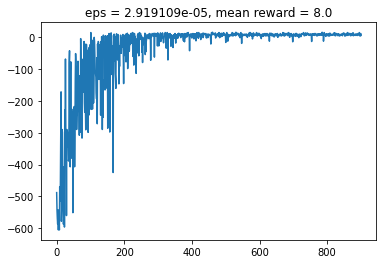

In [7]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        plt.title('eps = {:e}, mean reward = {:.1f}'.format(agent.epsilon, np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.show()